In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval
# import re
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import pickle

In [2]:
df = pd.read_csv("qns1.csv", converters={'code_snippets': literal_eval, 'Tag': literal_eval}, encoding='ISO-8859-1')

In [3]:
df.head()

,Id,CreationDate,Score,Title,Body,Tag,code_snippets,body_words,body_words_preprocessed_task1,title_preprocessed_task1,body_words_preprocessed_task2,title_preprocessed_task2,weight_title_body_preprocessed_task2,weight_title_body_preprocessed_task1
0,19280,2008-08-21T03:20:05Z,16,Code to ask yes/no question in javascript,<p>I could only find the function <code>confir...,[javascript],[],I could only find the function confirm() that ...,could function confirm ( ) ok/cancel button . ...,code yes/no question javascript,i could onli find the function confirm ( ) tha...,code to ask yes/no question in javascript,code to ask yes/no question in javascript code...,code yes/no question javascript code yes/no qu...
1,19970,2008-08-21T13:58:25Z,2,Best way to keep an ordered list of windows (f...,<p>What is the best way to manage a list of wi...,[javascript],[],What is the best way to manage a list of windo...,best way list window ( order ) abl next window...,best way order list window ( most-rec ) ?,what is the best way to manag a list of window...,best way to keep an order list of window ( fro...,best way to keep an order list of window ( fro...,best way order list window ( most-rec ) ? best...
2,22720,2008-08-22T15:58:13Z,3,Configure a Java Socket to fail-fast on discon...,<p>I have a listening port on my server that I...,"[java, exception, sockets, networking]",[],I have a listening port on my server that I'm ...,"port server java class socket interfac , i.e.i...",configur java socket fail-fast disconnect ?,i have a listen port on my server that i 'm co...,configur a java socket to fail-fast on disconn...,configur a java socket to fail-fast on disconn...,configur java socket fail-fast disconnect ? co...
3,29680,2008-08-27T07:40:01Z,5,Suppress NTLM dialog box after unauthorized re...,"<p>In a recent sharepoint project, I implement...","[asp.net, javascript, sharepoint]",[function Login() { var request = GetRequest...,"In a recent sharepoint project, I implemented ...","recent sharepoint project , authent webpart nt...",suppress dialog box unauthor request,"in a recent sharepoint project , i implement a...",suppress ntlm dialog box after unauthor request,suppress ntlm dialog box after unauthor reques...,suppress dialog box unauthor request suppress ...
4,30540,2008-08-27T16:02:00Z,6,What does this javascript error mean? Permissi...,<p>This error just started popping up all over...,"[javascript, flash]",[],This error just started popping up all over ou...,error site.permiss method googl post crossdoma...,javascript error mean ? permiss method,this error just start pop up all over our site...,what doe this javascript error mean ? permiss ...,what doe this javascript error mean ? permiss ...,javascript error mean ? permiss method javascr...


## CodeBERT

In [ ]:
import torch

from unixcoder import UniXcoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UniXcoder("microsoft/unixcoder-base-nine")
model.to(device)


UniXcoder(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51416, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
"""
Extract embeddings from a code snippet.
"""

def get_embeddings(text):

  tokens_ids = model.tokenize([text],max_length=512,mode="<encoder-only>")
  source_ids = torch.tensor(tokens_ids).to(device)
  tokens_embeddings,nl_embedding = model(source_ids)
  norm_nl_embedding = torch.nn.functional.normalize(nl_embedding, p=2, dim=1)
  norm_nl_embedding = norm_nl_embedding.detach().cpu().numpy()[0]
  return norm_nl_embedding

In [ ]:
%%time
code_embeddings = []

for code in df['code_snippets']:
  vector_database = []
  if code != []:
    for i in range(len(code)): #if there are multiple chunks of codes in one question
      vector_database.append(get_embeddings(code[i]))
  code_embeddings.append(vector_database)

df['code_embeddings'] = code_embeddings
df.head()

In [ ]:
preprocessed_text = [str(title) + ' ' + body for title, body in zip(df['title_preprocessed_task1'], df['body_words_preprocessed_task1'])]
vectorizer = TfidfVectorizer(max_features=150)
text_features = vectorizer.fit_transform(preprocessed_text)

max_length = max(len(embedding) for embedding in df['code_embeddings'])
max_inner_length = max(len(inner_array) for embedding in df['code_embeddings'] for inner_array in embedding)
flattened_max_length = max_length * max_inner_length


## Padding of code

In [ ]:
%%time

# ------------------------------------- CODE EMBEDDINGS WITH PADDING --------------------------------------
# Pad the code embeddings to the maximum length
padded_embeddings = []

for i, row in df.iterrows():
    embedding = row['code_embeddings']
    if embedding != []:  # Check if the embedding list is not empty
        padded_inner_arrays = [np.pad(inner_array, (0, max_inner_length - len(inner_array)), 'constant', constant_values=0) for inner_array in embedding]
#         print(i)
        flattened_embedding = np.concatenate(padded_inner_arrays).ravel()
    else:
        # If embedding is empty, create a zero-filled array of the appropriate flattened size
        flattened_embedding = np.zeros(flattened_max_length)

    # Ensure the flattened embedding has the correct final size
    final_padded_embedding = np.pad(flattened_embedding, (0, flattened_max_length - len(flattened_embedding)), 'constant', constant_values=0)
    padded_embeddings.append(final_padded_embedding)


In [ ]:
code_embeddings = np.array(padded_embeddings)
code_embeddings = code_embeddings.reshape(len(code_embeddings), -1)


In [ ]:
%%time
features = np.hstack((text_features.toarray(), code_embeddings))
features_list = features.tolist()
df['combined_embeddings_padded'] = features_list
df.head()


## OneVsRest Classifier (Solution 3)

In [ ]:
%%time
# Prepare binary target labels for each tag
unique_tags = df['Tag'].explode().unique()
target_labels = np.zeros((len(df), len(unique_tags)))
for i, tags in enumerate(df['Tag']):
    for tag in tags:
        target_labels[i, np.where(unique_tags == tag)] = 1

target_labels_list = target_labels.tolist()

# Split the data into training, testing and validation set
X_train, X_validation, y_train, y_validation = train_test_split(features_list, target_labels_list, test_size=0.25, random_state=99)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3333, random_state=99)

# Train the One-vs-Rest Linear SVC model
classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(X_train, y_train)

# Predict the top 3 tags for each data point
confidence_scores = classifier.decision_function(X_test)


In [ ]:
top_3_indices = np.argsort(confidence_scores, axis=1)[:, -3:]

# Translate these indices back to tag names
top_3_tags = []
for indices in top_3_indices:
    tags = [unique_tags[index] for index in indices]
    top_3_tags.append(tags)

# # Print the top 3 tags for each data point
# for i, tags in enumerate(top_3_tags):
#     print(f"Data point {i+1}: Top 3 tags - {tags}")

# Convert the predicted indices to binary labels
y_pred = np.zeros_like(y_test)
for i, indices in enumerate(top_3_indices):
    y_pred[i, indices] = 1

# Print the actual and predicted tags for each data point
for i in range(len(X_test)):
    actual_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_test[i][j] == 1]
    predicted_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_pred[i][j] == 1]
    print(f"Data point {i+1}:")
    print(f"  Actual tags: {actual_tags}")
    print(f"  Predicted tags: {predicted_tags}")
    

### Save model to pickle file

In [14]:
# save model to pickle file

pickle.dump(classifier, open('solution3_model400.sav', 'wb'))

In [15]:
pickle.dump(vectorizer, open('solution3_tfidf_vectorizer400.sav', 'wb'))

## Evaluation

In [17]:
# load model from pickle file

classifier = pickle.load(open('solution3_model400.sav','rb'))
vectorizer = pickle.load(open('solution3_tfidf_vectorizer400.sav', 'rb'))

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_score

### Evaluation of model on test data

In [17]:
# ----------------------------------------- BINARIZE THE DATA ------------------------------------------
y_true_list = []
y_pred_list = []
for i in range(len(X_test)):
    actual_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_test[i][j] == 1]
    predicted_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_pred[i][j] == 1]

    y_true_list.append(actual_tags)
    y_pred_list.append(predicted_tags)

# Binarize the labels
mlb = MultiLabelBinarizer()
y_true_binary = mlb.fit_transform(y_true_list)  # Fit on actual to cover all possible labels
y_pred_binary = mlb.transform(y_pred_list)  # Transform predictions using the same binarizer

/common/home/projectgrps/IS450/IS450G2/jupyterlab-venv-tf-py311/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['cocoa-touch'] will be ignored
  warnings.warn(


In [18]:
# ------------------------------------- EVALUATION: JACCARD SCORE --------------------------------------

# Calculate Jaccard similarity score
'''
  Choosing the average parameter: The average parameter in jaccard_score is crucial. If your dataset is imbalanced (some labels are much more frequent
  than others), consider using average='weighted'. If you're interested in a label-wise similarity, average='macro' might be suitable. The example uses
  average='samples', which computes the average Jaccard similarity across instances, a reasonable choice for evaluating overall prediction quality in
  multi-label classification.
'''
jaccard_similarity = jaccard_score(y_true_binary, y_pred_binary, average='weighted')

print("Jaccard Similarity:", jaccard_similarity)


Jaccard Similarity: 0.5835749613016896


### Evaluation of model on validation data

In [21]:
%%time
# Prepare binary target labels for each tag
unique_tags = df['Tag'].explode().unique()
target_labels = np.zeros((len(df), len(unique_tags)))
for i, tags in enumerate(df['Tag']):
    for tag in tags:
        target_labels[i, np.where(unique_tags == tag)] = 1

# # Predict the top 3 tags for each data point
confidence_scores = classifier.predict(X_validation)

CPU times: user 2min 45s, sys: 56.4 s, total: 3min 42s
Wall time: 2min 42s


In [22]:
top_3_indices = np.argsort(confidence_scores, axis=1)[:, -3:]

# Translate these indices back to tag names
top_3_tags = []
for indices in top_3_indices:
    tags = [unique_tags[index] for index in indices]
    top_3_tags.append(tags)

# Convert the predicted indices to binary labels
y_pred = np.zeros_like(y_validation)
for i, indices in enumerate(top_3_indices):
    y_pred[i, indices] = 1

# Print the actual and predicted tags for each data point
for i in range(len(X_validation)):
    actual_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_validation[i][j] == 1]
    predicted_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_pred[i][j] == 1]
    print(f"Data point {i+1}:")
    print(f"  Actual tags: {actual_tags}")
    print(f"  Predicted tags: {predicted_tags}")

Data point 1:
  Actual tags: ['javascript', 'html', 'jquery', 'php', 'arrays']
  Predicted tags: ['java', 'flex', 'nhibernate']
Data point 2:
  Actual tags: ['java']
  Predicted tags: ['java', 'flex', 'nhibernate']
Data point 3:
  Actual tags: ['javascript', 'asp.net', 'c#', 'ajax', 'json']
  Predicted tags: ['javascript', 'function', 'design-patterns']
Data point 4:
  Actual tags: ['javascript', 'asp.net', 'ajax', 'web-services', 'wcf']
  Predicted tags: ['javascript', 'ajax', 'flex']
Data point 5:
  Actual tags: ['javascript', 'jquery']
  Predicted tags: ['javascript', 'jquery', 'web-applications']
Data point 6:
  Actual tags: ['javascript', 'jquery']
  Predicted tags: ['javascript', 'jquery', 'web-applications']
Data point 7:
  Actual tags: ['javascript', 'html', 'jquery', 'arrays']
  Predicted tags: ['javascript', 'jquery', 'arrays']
Data point 8:
  Actual tags: ['javascript', 'jquery']
  Predicted tags: ['javascript', 'function', 'design-patterns']
Data point 9:
  Actual tags: ['j

In [25]:
# ----------------------------------------- BINARIZE THE DATA ------------------------------------------
y_true_list = []
y_pred_list = []
for i in range(len(X_test)):
    actual_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_test[i][j] == 1]
    predicted_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_pred[i][j] == 1]

    y_true_list.append(actual_tags)
    y_pred_list.append(predicted_tags)

# Binarize the labels
mlb = MultiLabelBinarizer()
y_true_binary = mlb.fit_transform(y_true_list)  # Fit on actual to cover all possible labels
y_pred_binary = mlb.transform(y_pred_list)  # Transform predictions using the same binarizer

/common/home/projectgrps/IS450/IS450G2/jupyterlab-venv-tf-py311/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['nhibernate'] will be ignored
  warnings.warn(


In [4]:
# ------------------------------------- EVALUATION: JACCARD SCORE --------------------------------------

# Calculate Jaccard similarity score
'''
  Choosing the average parameter: The average parameter in jaccard_score is crucial. If your dataset is imbalanced (some labels are much more frequent
  than others), consider using average='weighted'. If you're interested in a label-wise similarity, average='macro' might be suitable. The example uses
  average='samples', which computes the average Jaccard similarity across instances, a reasonable choice for evaluating overall prediction quality in
  multi-label classification.
'''
jaccard_similarity = jaccard_score(y_true_binary, y_pred_binary, average='weighted')

print("Jaccard Similarity:", jaccard_similarity)


Jaccard Similarity:  0.6194782748032348


## Demo

In [3]:
# load model from pickle file

classifier = pickle.load(open('solution3_model400.sav','rb'))
vectorizer = pickle.load(open('solution3_tfidf_vectorizer400.sav', 'rb'))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator _ConstantPredictor from version 1.4.1.post1 when using version 1.3.0. This mi

In [4]:
# title = input("Input the title of your question: ") # How can I remove a specific item from an array in JavaScript?
# print(title)

# description = input("Input the description of your question: ") # How do I remove a specific value from an array? Something like: Constraints: I have to use core JavaScript. Frameworks are not allowed.
# print(description)

# code = input("Input the code of your question: ") # array.remove(value);
# print(code)


In [7]:
# put into dataframe

df_demo = pd.DataFrame({
    'code_snippets': [[code]],
    'body_words_preprocessed_task1': [description],
    'title_preprocessed_task1': [title]
})

df_demo

,code_snippets,body_words_preprocessed_task1,title_preprocessed_task1
0,[array.remove(value);],How do I remove a specific value from an array...,How can I remove a specific item from an array...


In [10]:
import torch

from unixcoder import UniXcoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UniXcoder("microsoft/unixcoder-base")
model.to(device)

"""
Extract embeddings from a code snippet.
"""
def get_embeddings(text):

  tokens_ids = model.tokenize([text],max_length=512,mode="<encoder-only>")
  source_ids = torch.tensor(tokens_ids).to(device)
  tokens_embeddings,nl_embedding = model(source_ids)
  norm_nl_embedding = torch.nn.functional.normalize(nl_embedding, p=2, dim=1)
  norm_nl_embedding = norm_nl_embedding.detach().cpu().numpy()[0]
  return norm_nl_embedding


: 

In [ ]:
%%time
code_embeddings_demo = []

for code in df_demo['code_snippets']:
  vector_database = []
  if code != []:
    for i in range(len(code)): #if there are multiple chunks of codes in one question
      vector_database.append(get_embeddings(code[i]))
  code_embeddings_demo.append(vector_database)

df_demo['code_embeddings'] = code_embeddings_demo
df_demo.head()


CPU times: user 11.5 ms, sys: 67 µs, total: 11.6 ms
Wall time: 11.1 ms


,Tag,code_snippets,body_words_preprocessed_task1,title_preprocessed_task1,code_embeddings
0,[javascript],[array.remove(value);],How do I remove a specific value from an array...,How can I remove a specific item from an array...,"[[-0.006592125, 0.037436165, -0.02886976, 0.03..."


In [9]:
# ------------------------------------- CODE EMBEDDINGS WITH PADDING --------------------------------------
preprocessed_text_demo = [str(title) + ' ' + body for title, body in zip(df_demo['title_preprocessed_task1'], df_demo['body_words_preprocessed_task1'])]
text_features_demo = vectorizer.transform(preprocessed_text_demo)

print("Padded shape:\n", text_features_demo)

max_length = 2 # max(len(embedding) for embedding in df_demo['code_embeddings'])
max_inner_length = 768 # max(len(inner_array) for embedding in df_demo['code_embeddings'] for inner_array in embedding)
flattened_max_length = max_length * max_inner_length


Padded shape:
   (0, 376)	0.2690075099032455
  (0, 187)	0.2997773527359855
  (0, 184)	0.28874952083125005
  (0, 171)	0.3215547821660565
  (0, 159)	0.5781898794697075
  (0, 52)	0.3417166040137118
  (0, 30)	0.4471252179292336


In [34]:
%%time

# Pad the code embeddings to the maximum length
padded_embeddings_demo = []

for i, row in df_demo.iterrows():
    embedding = row['code_embeddings']
    if embedding != []:  # Check if the embedding list is not empty
        padded_inner_arrays = [np.pad(inner_array, (0, max_inner_length - len(inner_array)), 'constant', constant_values=0) for inner_array in embedding]
        # print(padded_inner_arrays)
        flattened_embedding = np.concatenate(padded_inner_arrays).ravel()
        # print(len(flattened_embedding))
    else:
        # If embedding is empty, create a zero-filled array of the appropriate flattened size
        flattened_embedding = np.zeros(flattened_max_length)

    # Ensure the flattened embedding has the correct final size
    final_padded_embedding = np.pad(flattened_embedding, (0, flattened_max_length - len(flattened_embedding)), 'constant', constant_values=0)
    padded_embeddings_demo.append(final_padded_embedding)

code_embeddings_demo = np.array(padded_embeddings_demo)

code_embeddings_demo = code_embeddings_demo.reshape(len(code_embeddings_demo), -1)


CPU times: user 7.83 ms, sys: 4 µs, total: 7.83 ms
Wall time: 7.84 ms


In [35]:
%%time
features_demo = np.hstack((text_features_demo.toarray(), code_embeddings_demo))
features_list_demo = features_demo.tolist()
df_demo['combined_embeddings_padded'] = features_list_demo
df_demo.head()


CPU times: user 103 µs, sys: 890 µs, total: 993 µs
Wall time: 832 µs


,Tag,code_snippets,body_words_preprocessed_task1,title_preprocessed_task1,code_embeddings,combined_embeddings_padded
0,[javascript],[array.remove(value);],How do I remove a specific value from an array...,How can I remove a specific item from an array...,"[[-0.006592125, 0.037436165, -0.02886976, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [42]:
confidence_scores = classifier.predict(features_list_demo)


In [43]:
top_3_indices = np.argsort(confidence_scores, axis=1)[:, -3:]

# Translate these indices back to tag names
top_3_tags = []
for indices in top_3_indices:
    tags = [unique_tags[index] for index in indices]
    top_3_tags.append(tags)

# # Print the top 3 tags for each data point
# for i, tags in enumerate(top_3_tags):
#     print(f"Data point {i+1}: Top 3 tags - {tags}")

# Convert the predicted indices to binary labels
y_pred = np.zeros_like(y_test)
for i, indices in enumerate(top_3_indices):
    y_pred[i, indices] = 1

# Print the actual and predicted tags for each data point
for i in range(len(X_test)):
    actual_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_test[i][j] == 1]
    predicted_tags = [unique_tags[j] for j in range(len(unique_tags)) if y_pred[i][j] == 1]
    print(f"Data point {i+1}:")
    print(f"  Actual tags: {actual_tags}")
    print(f"  Predicted tags: {predicted_tags}")

Data point 1: Top 3 tags - ['function', 'design-patterns', 'javascript']


## Plot Jaccard Score graph

In [12]:
import matplotlib.pyplot as plt

In [10]:
x_values = [200, 250, 300, 350, 400, 450, 500]
y_values = [0.561, 0.579, 0.591, 0.603, 0.608, 0.609, 0.610]

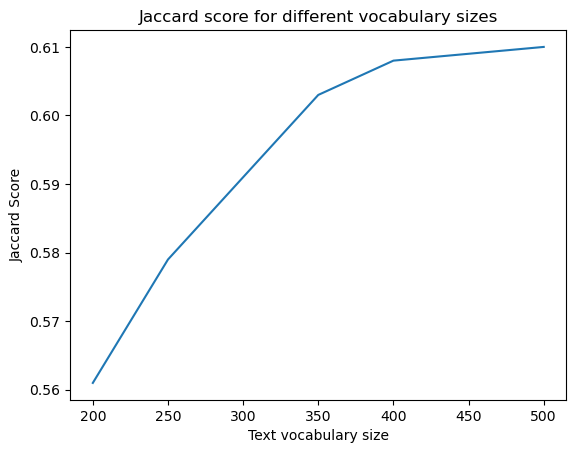

In [13]:
# Plot the data
plt.plot(x_values, y_values)

# Add labels and title
plt.xlabel('Text vocabulary size')
plt.ylabel('Jaccard Score')
plt.title('Jaccard score for different vocabulary sizes')

# Display the plot
plt.show()